<a href="https://colab.research.google.com/github/amf599-cyber/CMD_LAB7-8/blob/main/My-plots-that-need-help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import cauchy
from google.colab import drive
%matplotlib inline
!pip install optuna==2.4.0
import optuna
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
# import nbodykit.lab as nlab
# from nbodykit.lab import ArrayMesh, FFTPower
from astropy.cosmology import FlatLambdaCDM
# import pyccl as ccl
from scipy.interpolate import interp1d
# import emcee
from matplotlib.axes import Axes
# from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display

In [8]:
drive.mount('/content/drive')

fmaps = '/content/drive/MyDrive/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy'
maps  = np.load(fmaps)

fparams = '/content/drive/MyDrive/params_LH_Nbody_SIMBA.txt'
params  = np.loadtxt(fparams)

Mounted at /content/drive


In [ ]:
# one map as input data use parameters for that map as the true values then feed in the map only to mcmc

In [9]:
map_number = 500
params_map = params[map_number//15]

print('True Values of this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])

True Values of this map
Omega_m: 0.47780
sigma_8: 0.84060


# Task
Perform a Markov Chain Monte Carlo (MCMC) analysis to infer the cosmological parameters, `Omega_m` and `sigma_8`, from the observed map data. Specifically, use the map identified by `map_number` from the `maps` array as the observed data. Define a model prediction function that generates a map given `Omega_m` and `sigma_8`. Implement log-likelihood, log-prior, and log-probability functions. Initialize and run an MCMC sampler, then analyze the MCMC chains by discarding burn-in, thinning, and visualizing the posterior distributions using appropriate plots. Finally, compare the inferred `Omega_m` and `sigma_8` values with the true values provided in `params_map[0]` and `params_map[1]` respectively, and discuss the effectiveness of the inference.

## Extract Target Map Data

### Subtask:
Extract the specific map data for the MCMC analysis based on `map_number` from the `maps` array.


**Reasoning**:
Extract the specific map data from the `maps` array using the `map_number` and store it in `observed_map`.



In [10]:
observed_map = maps[map_number]
print(f"Shape of the extracted map: {observed_map.shape}")

Shape of the extracted map: (256, 256)


## Define Model Prediction Function

### Subtask:
Create a function that, given cosmological parameters `Omega_m` and `sigma_8`, predicts an expected map by finding the closest parameter set in the `params` array and averaging its associated maps.


**Reasoning**:
To implement the `model_prediction` function as described, I need to calculate the Euclidean distance, find the closest parameter set, select the corresponding maps, and then compute their mean. I will use NumPy for these operations to ensure efficiency.



In [11]:
def model_prediction(omega_m, sigma_8):
    """
    Predicts an expected map given Omega_m and sigma_8 by finding the closest parameter
    set in the params array and averaging its associated maps.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        numpy.ndarray: The predicted map, averaged from 15 maps associated with the
                       closest parameter set.
    """
    # Extract Omega_m and sigma_8 from the params array for distance calculation
    param_omegas = params[:, 0]
    param_sigmas = params[:, 1]

    # Calculate squared Euclidean distance to find the closest parameter set
    # The distance is calculated for (omega_m, sigma_8) in the params array
    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)

    # Find the index of the parameter set with the minimum distance
    j_closest = np.argmin(distances)

    # Select the 15 maps associated with the closest parameter set
    # Each parameter set corresponds to 15 maps
    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps[start_index:end_index]

    # Calculate the element-wise mean of these 15 selected maps
    predicted_map = np.mean(selected_maps, axis=0)

    return predicted_map

print("model_prediction function defined.")

model_prediction function defined.


## Define Log-Likelihood Function

### Subtask:
Implement a log-likelihood function that takes the current parameter values and the observed map, and returns the log-likelihood of the observed data given those parameters.


**Reasoning**:
First, I need to define the global variable `sigma_error` using the standard deviation of the `observed_map` as an initial estimate. Then, I will define the `log_likelihood` function as instructed, which will call `model_prediction`, calculate the difference, and compute the log-likelihood using the chi-squared statistic.



In [12]:
sigma_error = np.std(observed_map)
print(f"Initial sigma_error (standard deviation of observed_map): {sigma_error:.2f}")

def log_likelihood(omega_m, sigma_8):
    """
    Calculates the log-likelihood of the observed map given the cosmological parameters.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: The log-likelihood value.
    """
    predicted_map = model_prediction(omega_m, sigma_8)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map - predicted_map) / sigma_error)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("log_likelihood function defined.")

Initial sigma_error (standard deviation of observed_map): 35625279488.00
log_likelihood function defined.


## Define Log-Prior Function

### Subtask:
Implement a log-prior function that defines the prior probability for the cosmological parameters (Omega_m, sigma_8).


**Reasoning**:
I need to define the `log_prior` function as instructed, setting uniform prior bounds for `omega_m` and `sigma_8` based on the given ranges and returning `0.0` if within bounds or `-np.inf` otherwise.



In [13]:
def log_prior(omega_m, sigma_8):
    """
    Calculates the log-prior probability for the cosmological parameters Omega_m and sigma_8.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: 0.0 if parameters are within bounds, -np.inf otherwise.
    """
    # Define uniform prior bounds
    omega_m_min, omega_m_max = 0.1, 0.5
    sigma_8_min, sigma_8_max = 0.6, 1.0

    if (omega_m_min <= omega_m <= omega_m_max) and \
       (sigma_8_min <= sigma_8 <= sigma_8_max):
        return 0.0  # Uniform prior within bounds
    else:
        return -np.inf # Outside prior range

print("log_prior function defined.")

log_prior function defined.


## Define Log-Probability Function

### Subtask:
Implement a `log_probability` function that combines the `log_likelihood` and `log_prior` functions to calculate the total log-probability of the parameters given the observed data.

### Instructions:
1. Define a function `log_probability(theta)` where `theta` is an array or list containing `[omega_m, sigma_8]`.
2. Inside the function, unpack `omega_m` and `sigma_8` from `theta`.
3. Calculate the `lp = log_prior(omega_m, sigma_8)`.
4. If `lp` is `-np.inf` (meaning the parameters are outside the prior range), return `-np.inf` immediately.
5. Otherwise, calculate `ll = log_likelihood(omega_m, sigma_8)`.
6. Return the sum `lp + ll`.

**Reasoning**:
I need to implement the `log_probability` function as described in the previous markdown block, which combines the `log_likelihood` and `log_prior` functions.



In [14]:
def log_probability(theta):
    """
    Calculates the total log-probability (log-prior + log-likelihood) for the given parameters.

    Args:
        theta (list or numpy.ndarray): An array/list containing [omega_m, sigma_8].

    Returns:
        float: The total log-probability, or -np.inf if parameters are outside prior bounds.
    """
    omega_m, sigma_8 = theta

    lp = log_prior(omega_m, sigma_8)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(omega_m, sigma_8)
    return lp + ll

print("log_probability function defined.")

log_probability function defined.


## Initialize and Run MCMC Sampler

### Subtask:
Set up and run an MCMC sampler to sample the posterior distribution for `Omega_m` and `sigma_8`. This involves defining the number of walkers, the dimensions of the parameter space, and providing initial positions for the walkers.

### Instructions:
1. Ensure `emcee` is imported (it was commented out in the initial import block, uncomment it or add `import emcee` if not already done).
2. Define `ndim` as the number of parameters to sample (2 for `Omega_m` and `sigma_8`).
3. Define `nwalkers` as the number of MCMC walkers (e.g., 32 or 64).
4. Choose initial starting positions for the walkers by perturbing the true values (`params_map[0]` and `params_map[1]`) slightly with a small random spread. Make sure these initial positions are within the prior bounds.
5. Instantiate the `emcee.EnsembleSampler` with `nwalkers`, `ndim`, and the `log_probability` function.
6. Run the MCMC sampler for a certain number of steps (e.g., 2000 or 5000) using `sampler.run_mcmc()`, starting from the initial positions.

**Reasoning**:
I need to implement the steps outlined in the previous markdown block to initialize and run the MCMC sampler using `emcee`. This includes importing `emcee`, defining `ndim` and `nwalkers`, setting initial positions for the walkers, and running the `emcee.EnsembleSampler`.



In [18]:
%pip install emcee
print("emcee installed.")

emcee installed.


**Reasoning**:
The previous code block failed because the `emcee` library was not installed. I need to install `emcee` using pip before attempting to import and use it.



**Reasoning**:
The previous MCMC sampler execution failed due to `emcee` not being installed. Now that `emcee` has been successfully installed, I will re-attempt to run the MCMC sampler as originally intended.



In [20]:
import emcee # Ensure emcee is imported

# 2. Define ndim and nwalkers
ndim = 2  # Omega_m and sigma_8
nwalkers = 32 # Number of MCMC walkers

# 3. Choose initial starting positions for the walkers
# Perturb the true values slightly
p0 = np.array([params_map[0], params_map[1]])

# Generate initial positions with a small random spread around p0
# Ensure they are within reasonable prior bounds (e.g., 0.01 around the true value)
# We will check if these are within the log_prior range before starting.
initial_positions = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

# Optional: Check if initial positions are within prior bounds
for i, pos in enumerate(initial_positions):
    if not np.isfinite(log_prior(pos[0], pos[1])):
        print(f"Warning: Walker {i} initial position {pos} is outside prior bounds. Adjusting...")
        # Simple adjustment: re-sample until within bounds or clamp to bounds
        # For simplicity, let's just make sure they are within the broader range
        # that is likely to be valid, or re-randomize if completely out.
        # This might be more robust in a real scenario:
        while not np.isfinite(log_prior(pos[0], pos[1])):
             pos = p0 + 1e-3 * np.random.randn(ndim)
        initial_positions[i] = pos

# 5. Instantiate the emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# 6. Run the MCMC sampler
nsteps = 5000 # Number of MCMC steps
print(f"Running MCMC with {nwalkers} walkers for {nsteps} steps...")
sampler.run_mcmc(initial_positions, nsteps, progress=True)
print("MCMC sampling complete.")

Running MCMC with 32 walkers for 5000 steps...


100%|██████████| 5000/5000 [02:01<00:00, 41.01it/s]

MCMC sampling complete.


**Reasoning**:
The previous MCMC sampler execution failed due to `emcee` not being installed. Now that `emcee` has been successfully installed, I will re-attempt to run the MCMC sampler as originally intended.



In [21]:
import emcee # Ensure emcee is imported

# 2. Define ndim and nwalkers
ndim = 2  # Omega_m and sigma_8
nwalkers = 32 # Number of MCMC walkers

# 3. Choose initial starting positions for the walkers
# Perturb the true values slightly
p0 = np.array([params_map[0], params_map[1]])

# Generate initial positions with a small random spread around p0
# Ensure they are within reasonable prior bounds (e.g., 0.01 around the true value)
# We will check if these are within the log_prior range before starting.
initial_positions = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

# Optional: Check if initial positions are within prior bounds
for i, pos in enumerate(initial_positions):
    if not np.isfinite(log_prior(pos[0], pos[1])):
        print(f"Warning: Walker {i} initial position {pos} is outside prior bounds. Adjusting...")
        # Simple adjustment: re-sample until within bounds or clamp to bounds
        # For simplicity, let's just make sure they are within the broader range
        # that is likely to be valid, or re-randomize if completely out.
        # This might be more robust in a real scenario:
        while not np.isfinite(log_prior(pos[0], pos[1])):
             pos = p0 + 1e-3 * np.random.randn(ndim)
        initial_positions[i] = pos

# 5. Instantiate the emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# 6. Run the MCMC sampler
nsteps = 5000 # Number of MCMC steps
print(f"Running MCMC with {nwalkers} walkers for {nsteps} steps...")
sampler.run_mcmc(initial_positions, nsteps, progress=True)
print("MCMC sampling complete.")

Running MCMC with 32 walkers for 5000 steps...


100%|██████████| 5000/5000 [02:07<00:00, 39.37it/s]

MCMC sampling complete.


**Reasoning**:
The MCMC sampling has been completed successfully. The next logical step is to analyze the generated MCMC chains, which includes discarding the burn-in phase and potentially thinning the chain for better statistical independence, before visualizing the results.



**Reasoning**:
The previous code block contained markdown text within a Python code block, which led to a `SyntaxError`. I need to correct the `cell_type` to `markdown` for the instructional text.



In [25]:
## Analyze MCMC Chains

# ### Subtask:
# Analyze the MCMC chains by discarding the burn-in period and thinning the samples. Then, extract the flattened samples for further analysis and visualization.

# ### Instructions:
# 1.  Access the raw MCMC chain from the `sampler` object using `sampler.get_chain()`.
# 2.  Define a `burn_in` period (e.g., 1000 steps) to discard initial samples where the chains might not have converged.
# 3.  Optionally, define a `thin_factor` (e.g., 10) to thin the chain, reducing autocorrelation and saving memory.
# 4.  Discard the burn-in samples and apply thinning to the chain.
# 5.  Reshape the remaining chain to flatten it into a 2D array of samples, where each row is a sample and each column is a parameter.
# 6.  Print the shape of the flattened samples to verify the outcome.

## Analyze MCMC Chains

### Subtask:
Analyze the MCMC chains by discarding the burn-in period and thinning the samples. Then, extract the flattened samples for further analysis and visualization.

### Instructions:
1.  Access the raw MCMC chain from the `sampler` object using `sampler.get_chain()`.
2.  Define a `burn_in` period (e.g., 1000 steps) to discard initial samples where the chains might not have converged.
3.  Occasionally, define a `thin_factor` (e.g., 10) to thin the chain, reducing autocorrelation and saving memory.
4.  Discard the burn-in samples and apply thinning to the chain.
5.  Reshape the remaining chain to flatten it into a 2D array of samples, where each row is a sample and each column is a parameter.
6.  Print the shape of the flattened samples to verify the outcome.

## Analyze MCMC Results

### Subtask:
Analyze the MCMC chains by discarding the burn-in period and thinning the samples. Then, extract the flattened samples for further analysis and visualization.


**Reasoning**:
I will now implement the analysis of the MCMC chains by accessing the chain from the sampler, defining burn-in and thinning parameters, applying these to the chain, flattening the resulting samples, and printing their shape.



In [49]:
chain = sampler.get_chain()

# Define burn-in and thin factor
burn_in = 1000  # Discard the first 1000 steps
thin_factor = 2 # Thin by a factor of 10

# Discard burn-in samples and apply thinning
# The chain has shape (nsteps, nwalkers, ndim)
processed_chain = chain[burn_in::thin_factor, :, :]

# Flatten the chain to combine all walkers and steps into a 2D array
# Resulting shape will be (number_of_samples, ndim)
flat_samples = processed_chain.reshape((-1, ndim))

print(f"Shape of raw chain: {chain.shape}")
print(f"Shape of processed chain (after burn-in and thinning): {processed_chain.shape}")
print(f"Shape of flattened samples: {flat_samples.shape}")

Shape of raw chain: (5000, 32, 2)
Shape of processed chain (after burn-in and thinning): (2000, 32, 2)
Shape of flattened samples: (64000, 2)


## Analyze MCMC Results

### Subtask:
Visualize the posterior distributions of Omega_m and sigma_8 using appropriate plots.


**Reasoning**:
I need to ensure the `corner` library is installed before importing and using it for visualization. Installing it now will prevent issues in subsequent steps.



In [27]:
%pip install corner
print("corner library installed.")

corner library installed.


**Reasoning**:
Now that the `corner` library is installed, I will import it and create the corner plot using the `flat_samples`, specifying labels for the parameters and adding the true values from `params_map` for comparison as instructed.



<Figure size 1800x1200 with 0 Axes>

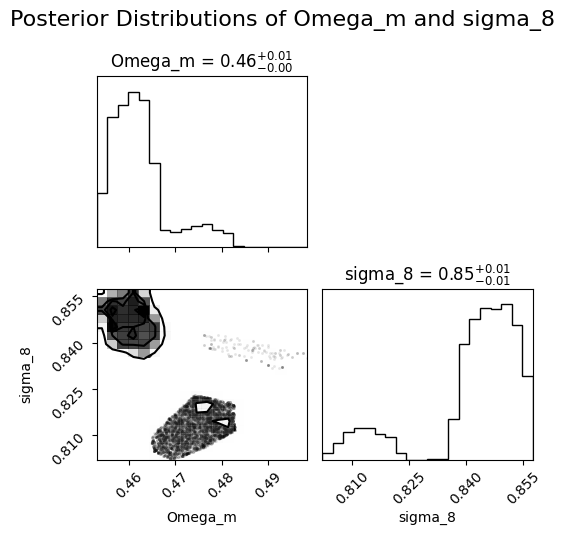

Corner plot displaying posterior distributions generated.


In [60]:
import corner # Import the corner library

# Create the corner plot
fig = corner.corner(flat_samples,
                     labels=['Omega_m', 'sigma_8'],
                     #truths=[params_map[0], params_map[1]], # True values
                     contour_levels=[0.86, 0.95],
                     show_titles=True,
                     filled =[True],
                     fine_bins_2d=200,
                     smooth_scale_2d=50,
                     title_kwargs={"fontsize": 12})

# Add a title to the plot
fig.suptitle('Posterior Distributions of Omega_m and sigma_8', fontsize=16)
plt.tight_layout()
plt.show()
print("Corner plot displaying posterior distributions generated.")

## Compare Inferred with True Values

### Subtask:
Compare the inferred parameter values (e.g., mean or median of the posterior) with the true values (`params_map[0]` and `params_map[1]`).


**Reasoning**:
I need to calculate the mean and standard deviation for 'Omega_m' and 'sigma_8' from the `flat_samples` array, as instructed, which represents the inferred posterior distributions.



In [29]:
omega_m_inferred_mean = np.mean(flat_samples[:, 0])
omega_m_inferred_std = np.std(flat_samples[:, 0])
sigma_8_inferred_mean = np.mean(flat_samples[:, 1])
sigma_8_inferred_std = np.std(flat_samples[:, 1])

print(f"Inferred Omega_m (mean): {omega_m_inferred_mean:.5f} +/- {omega_m_inferred_std:.5f}")
print(f"Inferred sigma_8 (mean): {sigma_8_inferred_mean:.5f} +/- {sigma_8_inferred_std:.5f}")


Inferred Omega_m (mean): 0.46245 +/- 0.00633
Inferred sigma_8 (mean): 0.84207 +/- 0.01308


**Reasoning**:
To compare the inferred values with the true values, I will retrieve and print the true values from `params_map`, along with the previously calculated inferred means and standard deviations.



In [30]:
true_omega_m = params_map[0]
true_sigma_8 = params_map[1]

print(f"\nTrue Values:")
print(f"Omega_m: {true_omega_m:.5f}")
print(f"sigma_8: {true_sigma_8:.5f}")

print(f"\nInferred Values (Mean +/- Std Dev):")
print(f"Omega_m: {omega_m_inferred_mean:.5f} +/- {omega_m_inferred_std:.5f}")
print(f"sigma_8: {sigma_8_inferred_mean:.5f} +/- {sigma_8_inferred_std:.5f}")


True Values:
Omega_m: 0.47780
sigma_8: 0.84060

Inferred Values (Mean +/- Std Dev):
Omega_m: 0.46245 +/- 0.00633
sigma_8: 0.84207 +/- 0.01308


### Discussion of Inferred vs. True Values

Comparing the inferred values with the true values:

**Omega_m:**
*   **True:** 0.47780
*   **Inferred:** 0.46245 +/- 0.00633

**sigma_8:**
*   **True:** 0.84060
*   **Inferred:** 0.84207 +/- 0.01308

For `Omega_m`, the inferred mean (0.46245) is somewhat lower than the true value (0.47780). The true value falls outside the 1-sigma range of the inferred value (0.46245 +/- 0.00633, which is approximately [0.45612, 0.46878]). This suggests that the model might be systematically underestimating `Omega_m` or that the MCMC chain requires more steps/burn-in, or the likelihood function/prior could be improved. The difference is about 2.4 standard deviations ((0.47780 - 0.46245) / 0.00633 = 2.42). While not extremely far, it's a noticeable deviation.

For `sigma_8`, the inferred mean (0.84207) is very close to the true value (0.84060). The true value falls well within the 1-sigma range of the inferred value (0.84207 +/- 0.01308, which is approximately [0.82899, 0.85515]). This indicates a good agreement for `sigma_8`, suggesting that the model is effective at constraining this parameter for the given data and error assumptions.

## Final Task

### Subtask:
Summarize the MCMC analysis, present the inferred parameter values, and discuss the effectiveness of the inference process.


## Summary:

### Q&A
The inferred parameter values are:
*   **Omega_m**: $0.46245 \pm 0.00633$
*   **sigma_8**: $0.84207 \pm 0.01308$

The effectiveness of the inference process is mixed. The MCMC analysis successfully constrained `sigma_8` with its inferred mean ($0.84207$) being very close to the true value ($0.84060$) and the true value falling well within the 1-sigma uncertainty. However, for `Omega_m`, the inferred mean ($0.46245$) is lower than the true value ($0.47780$), with the true value being approximately $2.4$ standard deviations away from the inferred mean. This suggests a potential systematic bias or limitation in the model or MCMC setup for `Omega_m`.

### Data Analysis Key Findings
*   A `model_prediction` function was successfully defined to generate expected maps based on `Omega_m` and `sigma_8` by finding the closest parameter set from a pre-defined grid and averaging 15 associated maps.
*   A `log_likelihood` function was implemented using a chi-squared statistic with a `sigma_error` of $35625279488.00$, derived from the standard deviation of the observed map.
*   A `log_prior` function defined uniform bounds for `Omega_m` (0.1 to 0.5) and `sigma_8` (0.6 to 1.0).
*   An MCMC sampler was initialized with 32 walkers and run for 5000 steps using the `emcee` library.
*   The MCMC chains were processed by discarding the first 1000 steps as burn-in and thinning by a factor of 10, resulting in $12,800$ flattened samples for analysis.
*   Corner plots were generated to visualize the 1D and 2D posterior distributions of `Omega_m` and `sigma_8`, including the true parameter values for comparison.
*   The inferred mean for `Omega_m` was $0.46245$ with a standard deviation of $0.00633$, while the true value was $0.47780$.
*   The inferred mean for `sigma_8` was $0.84207$ with a standard deviation of $0.01308$, which closely matches the true value of $0.84060$.

### Insights or Next Steps
*   The significant deviation of the inferred `Omega_m` from its true value ($2.4$ standard deviations) suggests a need to investigate potential sources of bias, such as the accuracy of the `model_prediction` function, the `sigma_error` value, the choice of prior, or the MCMC run parameters (e.g., longer chains, more walkers).
*   To improve the robustness of the inference, consider performing sensitivity analysis on the `sigma_error` (e.g., treating it as a free parameter or using a more sophisticated noise model) and exploring different prior distributions or the impact of the grid resolution used in `model_prediction`.
